In [1]:
setwd('/home/other/jpf5265/DnDs-visualization/Hierarchical_Edge_Bundling_tree/demo_for_Judith')

In [6]:
# Switch to R
library(tidyverse)
library(viridis)
library(patchwork)
library(ggraph)
library(igraph)
library(RColorBrewer)
library(dplyr)
library(tidyr)

In [9]:
# Step1: Read in the raw taxonomy files for both Archaea and Bacteria
# Taxonomy for Archaea (Read in the raw taxonomy file)
archaea_taxonomy_raw <- read.csv('ar53_taxonomy_r214.tsv', sep = '\t', header = FALSE)
colnames(archaea_taxonomy_raw) <- c('Assembly ID', 'lineage')

# Taxonomy for Bacteria (Read in the raw taxonomy file)
bacteria_taxonomy_raw <- read.csv('bac120_taxonomy_r214.tsv', sep = '\t', header = FALSE)
colnames(bacteria_taxonomy_raw) <- c('Assembly ID', 'lineage')

In [11]:
# Step 2: Clean the archaea taxonomy raw data
archaea_taxonomy <- archaea_taxonomy_raw %>%
  mutate(`Assembly ID` = gsub("^.{2}_", "", `Assembly ID`)) %>%  # Remove first two characters and underscore
  mutate(root = "Root") %>%  # Add the "root" column with all values as "Root"
  relocate(root, .after = `Assembly ID`) %>%  # Place the "root" column after "Assembly ID"
  separate(lineage, into = c("superkingdom", "phylum", "class", "order", "family", "genus", "species"),
           sep = ";", remove = TRUE) %>%  # Split lineage into taxonomy columns
  mutate(across(superkingdom:species, ~ gsub("^[dpcfogs]__", "", .)))

# Clean the bacteria taxonomy raw data
bacteria_taxonomy <- bacteria_taxonomy_raw %>%
  mutate(`Assembly ID` = gsub("^.{2}_", "", `Assembly ID`)) %>%  # Remove first two characters and underscore
  mutate(root = "Root") %>%  # Add the "root" column with all values as "Root"
  relocate(root, .after = `Assembly ID`) %>%  # Place the "root" column after "Assembly ID"
  separate(lineage, into = c("superkingdom", "phylum", "class", "order", "family", "genus", "species"),
           sep = ";", remove = TRUE) %>%  # Split lineage into taxonomy columns
  mutate(across(superkingdom:species, ~ gsub("^[dpcfogs]__", "", .)))

# Append the archaea and bacteria taxonomy data
lineage_information_new <- rbind(archaea_taxonomy, bacteria_taxonomy)

In [12]:
# Export to CSV
write.csv(lineage_information_new, file = "lineage_information_new.csv", row.names = FALSE, quote = FALSE)

In [17]:
# Step 3: Clean the 'query_name' and 'match_name' columns in the 'fmh_omega_7_for_HEB_figure_further_filter_query_name_x' dataset

# Define file path
file_path <- "fmh_omega_7_for_HEB_figure_further_filter_query_name_x.csv"

# Read the CSV file
fmh_omega_7 <- read.csv(file_path, sep = ",", header = TRUE)


# Filter rows where 'query_name' and 'match_name' are in the column "Assembly ID" of lineage_information_new
fmh_omega_7_short <- fmh_omega_7[
  fmh_omega_7$query_name %in% lineage_information_new$`Assembly ID` &
  fmh_omega_7$match_name %in% lineage_information_new$`Assembly ID`,
]

# Select specific columns: 'query_name', 'match_name', and 'dN/dS'
fmh_omega_7_short <- fmh_omega_7_short[, c("query_name", "match_name", "dN.dS")]


In [18]:
# Export to CSV
write.csv(fmh_omega_7_short, file = "fmh_omega_7_short.csv", row.names = FALSE, quote = FALSE)

In [32]:
# Step 4: Clean taxonomy and dnds datasets, selecting columns that are needed
taxonomy <- read.csv('lineage_information_new.csv')
dnds <- read.csv('fmh_omega_7_short.csv')

dnds <- dnds %>%
  filter(!is.na(dN.dS)) %>%
  rename(from = query_name, to = match_name, dndsvalue = dN.dS) %>%
  select(from, to, dndsvalue)


# Keep only Assembly.ID present in dnds$query_name or dnds$match_name
taxonomy_selected <- taxonomy %>%
  filter(Assembly.ID %in% unique(c(dnds$from, dnds$to)))


In [33]:
# # Step 5: Check for mutual pairs such as from genome A to genome B and from genome B to genome A in dnds dataset
mutual_check <- merge(dnds, dnds, by.x = c("from", "to"), by.y = c("to", "from"))

# Output the result
if (nrow(mutual_check) > 0) {
  print("Mutual connections found:")
  print(mutual_check)
} else {
  print("No mutual connections found.")
}

[1] "No mutual connections found."


In [34]:
# # Step 6: # Find out all genomes ids that are in the isolated pair. 
# The isolated pair here means each genome in this pair only connects to other genomes that only exists in this pair

# Create an undirected graph from the edge list
g <- graph_from_data_frame(dnds, directed = FALSE)

# Find connected components
comps <- components(g)

# Get component sizes
component_sizes <- comps$csize

# Get the membership vector
membership <- comps$membership

# Find components of size 2 (which connects with one and only one other genome)
components_of_size_two <- which(component_sizes == 2)

# Initialize vector to store genome IDs in isolated pairs
isolated_genomes <- c()

# Loop through each component of size 2
for (comp in components_of_size_two) {
  # Get the nodes in this component
  nodes_in_comp <- names(membership[membership == comp])
  # Add them to isolated_genomes
  isolated_genomes <- c(isolated_genomes, nodes_in_comp)
}

# Remove duplicate entries
isolated_genomes <- unique(isolated_genomes)


In [87]:
# # Step 7: # Based on the dnds dataset, removing all species that contained isolated_genomes ID in Step 6 
# since we do not want to show gemones that connects only one another genome in the visualization
# filter dnds to keep the visulation clean (Optional in this demo, if we do apply this step, connect will be the same as dnds)

######################### Apply this step if we want to remove isolated genomes in the visualization #########################
# connect <- dnds[!(dnds$from %in% isolated_genomes), ]

# connect <- dnds[!(dnds$from %in% isolated_genomes), ] %>%
#   # filter((dndsvalue >= 0 & dndsvalue <= 0.9 | dndsvalue >= 1.1 & dndsvalue <= 3))
#   filter(dndsvalue > 0.8 & dndsvalue < 1)
#   # filter(dndsvalue > 1)
#############################################################################################################################
connect <- dnds

In [88]:
# Step 8: Merge taxonomy information with the 'connect' dataset to 
# ensure both genome A and genome B have taxonomy information for a given taxonomic level such as genus

# Merge taxonomy information for the 'from' column
connect_with_from <- connect %>%
  left_join(taxonomy_selected, by = c("from" = "Assembly.ID")) %>%
  rename(root_from = root, 
         superkingdom_from = superkingdom, 
         phylum_from = phylum, 
         class_from = class, 
         order_from = order, 
         family_from = family, 
         genus_from = genus, 
         species_from = species)

# Merge taxonomy information for the 'to' column
connect_with_taxonomy <- connect_with_from %>%
  left_join(taxonomy_selected, by = c("to" = "Assembly.ID")) %>%
  rename(root_to = root, 
         superkingdom_to = superkingdom, 
         phylum_to = phylum, 
         class_to = class, 
         order_to = order, 
         family_to = family, 
         genus_to = genus, 
         species_to = species)

connect_with_taxonomy_updated<-connect_with_taxonomy %>%
  filter(genus_from != "" & !is.na(genus_from),  # Ensure genus_from is not empty or NA
         genus_to != "" & !is.na(genus_to), # Ensure genus_to is not empty or NA
         superkingdom_from == superkingdom_to # Ensure the superkingdoms are the same
        #  superkingdom_from == 'Bacteria' &  superkingdom_to == 'Bacteria'   # Ensure both superkingdom_from and superkingdom_to are 'Bacteria'
        #  superkingdom_from == 'Archaea' &  superkingdom_to == 'Archaea'   # Ensure both superkingdom_from and superkingdom_to are 'Archaea'
         
         ) 

cat("Number of valid edges (with positions):", nrow(connect_with_taxonomy_updated), "\n")

Number of valid edges (with positions): 96 


In [89]:
# Step 9: Clean the taxonomy_selected df to keep only the nodes (valid nodes) that are present 
# in the filtered connect df in Step 8
taxonomy_selected_final <- taxonomy_selected[taxonomy_selected$Assembly.ID %in% unique(c(connect_with_taxonomy_updated$from, connect_with_taxonomy_updated$to)), ]
cat("Number of valid nodes:", nrow(taxonomy_selected_final), "\n")


Number of valid nodes: 57 


In [90]:
# Step 10: Create hierarcy and vertices for hierarchical edge bundling visualization

# Add a root column to the taxonomy data, reshape the data into long format
taxonomy_long <- taxonomy_selected_final %>%
  select(Assembly.ID, root, superkingdom, phylum, class, order, family, genus, species) %>%
  mutate(root = if_else(root == "cellular organisms", "Root", root)) %>%
      # Create hierarchical relationships
  pivot_longer(cols = c(root, superkingdom, phylum, class, order, family, genus, species, Assembly.ID),
               names_to = "level",
               values_to = "name") %>%
  mutate(genome_id = rep(taxonomy_selected_final$Assembly.ID, each = 9)) # 9 is the numbers of columns in taxonomy_selected

  # Create hierarchical relationships
hierarchy <- taxonomy_long %>%

  # sorting taxomomic level within each genome ("genome_id")
  arrange(genome_id, match(level, c("root", "superkingdom", "phylum", "class", "order", "family", "genus", "species", "Assembly.ID"))) %>%
  group_by(genome_id) %>%

  # from = lag(name): Take the value from the previous row in the column "name" and assigns it to a new column called from, 
  # to = name: Set the value in column "to" the value in the name column.
  mutate(from = lag(name), to = name)  %>%
  filter(!is.na(from)) %>%
  select(from, to, genome_id) %>%
  distinct() %>%
  ungroup() %>%
  distinct(from, to)

vertices <- data.frame(name = unique(c(as.character(hierarchy$from), as.character(hierarchy$to))))
nrow(vertices)

[1] 135

In [91]:
# Attempt 1:
set.seed(399)
library(ggraph)
library(igraph)
library(dplyr)


# Create the graph object
vertices <- data.frame(name = unique(c(as.character(hierarchy$from), as.character(hierarchy$to))), value = runif(nrow(vertices))) 
mygraph <- graph_from_data_frame(hierarchy, vertices = vertices)


from <- match(connect_with_taxonomy_updated$from, vertices$name)
to <- match(connect_with_taxonomy_updated$to, vertices$name)

In [92]:
# Step 11: Retain layout data for only the nodes that are connected by valid edges
# create the layout so we can feed to to get_con and manipulate the data frame directly for plotting
layout_data <- create_layout(mygraph, layout = 'dendrogram', circular = TRUE)

# # 'from' and 'to' are vectors of node indices or names
conn_function <- get_con(from = from, to = to)
conn_data_frame <- conn_function(layout_data)

# # # Add connection values to `conn_data_frame`. This is one of the key steps of getting the connections/dNdS values to match up with the actual plot
conn_data_frame$con.value <- connect_with_taxonomy_updated$dndsvalue[conn_data_frame$con.id]

# Remove invalid connections where genomes are not in connect_new
conn_data_frame <- conn_data_frame[!is.na(conn_data_frame$con.value), ]

sum(conn_data_frame$leaf == 'TRUE')

[1] 192

In [93]:
# Step 12: Determine the coordinates of the genus label
genome_coordinate<-unique(conn_data_frame[conn_data_frame$leaf == TRUE, c('name','x','y')])

genome_coordinate_info <- merge(
  genome_coordinate, 
  taxonomy_selected_final[, c("Assembly.ID", "phylum", "class", "order", "family", "genus", "species")],
  by.x = "name", 
  by.y = "Assembly.ID", 
  all.x = TRUE
)

# Function to calculate center coordinates for each genus
calculate_genus_centers <- function(data, taxonomy_level_column, x_column, y_column) {
  # Group by genus and calculate the mean x and y coordinates
  centers <- data %>%
    group_by(!!sym(taxonomy_level_column)) %>%
    summarise(
      center_x = mean(!!sym(x_column)),
      center_y = mean(!!sym(y_column)),
      .groups = 'drop'
    )
  return(centers)
}

taxonomy_level_column<-"genus" # Can change to any other taxonomy levels such as family


# Dynamically create the name for genus_centers
centers_name <- paste0(taxonomy_level_column, "_centers")

# Calculate centers and assign to dynamically named variable
assign(centers_name, calculate_genus_centers(genome_coordinate_info, 
                                             taxonomy_level_column = taxonomy_level_column, 
                                             x_column = "x", 
                                             y_column = "y"))

# nrow(genus_centers)

cat("Number of unique", taxonomy_level_column, "groups:", nrow(genus_centers), "\n")

Number of unique genus groups: 4 


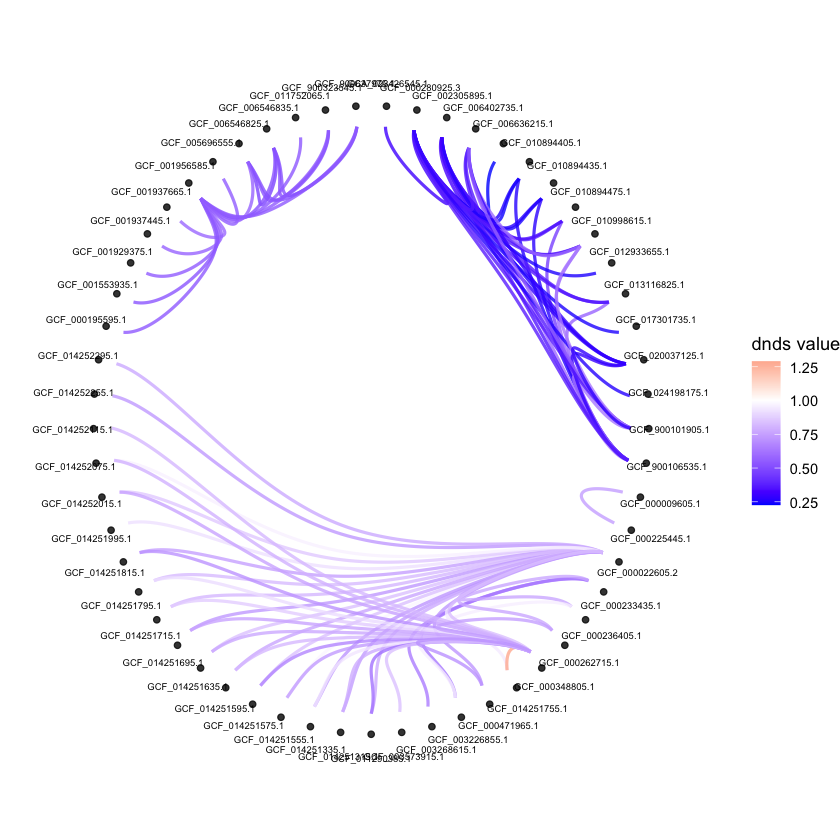

In [94]:
# Step 13a: Generate a graph based on genomes and their dN/dS values, labelling each dot on the circle represents a genome
ggraph(mygraph, layout = 'dendrogram', circular = TRUE) + 
  geom_conn_bundle(
    data = conn_data_frame, 
    alpha = 0.8, 
    width = 0.9, 
    aes(edge_colour = con.value)
  ) +  # Adjust edge colors based on `con.value`
  geom_node_text(
    aes(
      x = x * 1.15, 
      y = y * 1.15, 
      filter = leaf, 
      label = name
    ), 
    size = 2, 
    alpha = 1
  ) +  # Remove color from nodes
  geom_node_point(
    aes(
      filter = leaf, 
      x = x * 1.07, 
      y = y * 1.07
    ), 
    alpha = 0.8
  ) +  # Remove color from points
  scale_edge_colour_gradient2(
    low = "blue",    # Blue for negative values
    mid = "white",  # White for zero
    high = "red",  # Red for positive values
    midpoint = 1,  # Center of gradient
    name = "dnds value"
    
  ) +
  scale_size_continuous(range = c(1, 3)) +  # Size scale for node points
  theme_void() +
  expand_limits(x = c(-1.3, 1.3), y = c(-1.3, 1.3))

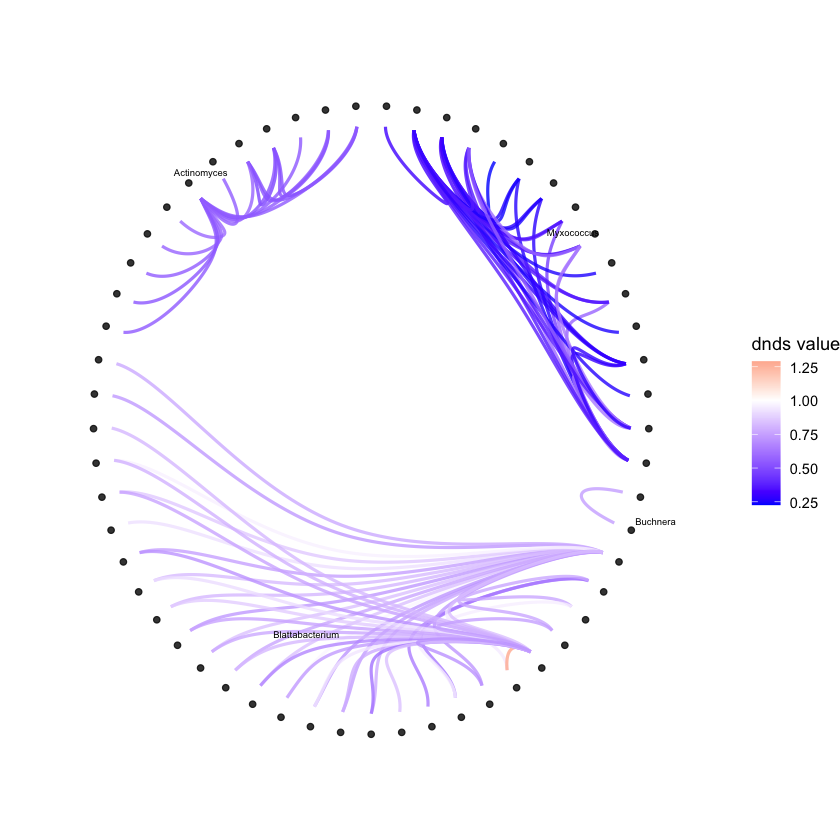

In [96]:
# Step 13b: Labelling based on genus groups
ggraph(mygraph, layout = 'dendrogram', circular = TRUE) + 
  geom_conn_bundle(
    data = conn_data_frame, 
    alpha = 0.8, 
    width = 0.9, 
    aes(edge_colour = con.value)
  ) +  # Adjust edge colors based on `con.value`
  geom_text(
    data = genus_centers,  # Use the genus_centers dataframe
    aes(
      x = center_x * 1.15,  # Adjust x for genus labels
      y = center_y * 1.15,  # Adjust y for genus labels
      label = genus         # Use the genus column for labels
    ),
    size = 2, 
    alpha = 1
  ) +  # Remove color from points
  geom_node_point(
    aes(
      filter = leaf, 
      x = x * 1.07, 
      y = y * 1.07
    ), 
    alpha = 0.8
  ) +  # Remove color from points
  scale_edge_colour_gradient2(
    low = "blue",    # Blue for negative values
    mid = "white",  # White for zero
    high = "red",  # Red for positive values
    midpoint = 1,  # Center of gradient
    name = "dnds value"
    
  ) +
  scale_size_continuous(range = c(1, 3)) +  # Size scale for node points
  theme_void() +
  expand_limits(x = c(-1.3, 1.3), y = c(-1.3, 1.3))

In [97]:
genome_coordinate_info

name,x,y,phylum,class,order,family,genus,species
<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
GCA_023426545.1,5.508776e-02,0.99848152,Myxococcota,Myxococcia,Myxococcales,Myxococcaceae,Myxococcus,Myxococcus sp023426545
GCF_000009605.1,9.694003e-01,-0.24548549,Pseudomonadota,Gammaproteobacteria,Enterobacterales,Enterobacteriaceae,Buchnera,Buchnera aphidicola_I
GCF_000022605.2,8.922542e-01,-0.45153336,Bacteroidota,Bacteroidia,Flavobacteriales,Blattabacteriaceae,Blattabacterium,Blattabacterium sp000022605
GCF_000195595.1,-9.544050e-01,0.29851481,Actinomycetota,Actinomycetia,Actinomycetales,Actinomycetaceae,Actinomyces,Actinomyces sp000195595
GCF_000225445.1,9.365112e-01,-0.35063756,Pseudomonadota,Gammaproteobacteria,Enterobacterales,Enterobacteriaceae,Buchnera,Buchnera aphidicola_A
GCF_000233435.1,8.371665e-01,-0.54694816,Bacteroidota,Bacteroidia,Flavobacteriales,Blattabacteriaceae,Blattabacterium,Blattabacterium sp000233435
GCF_000236405.1,7.719167e-01,-0.63572375,Bacteroidota,Bacteroidia,Flavobacteriales,Blattabacteriaceae,Blattabacterium,Blattabacterium punctulatus
GCF_000262715.1,6.972968e-01,-0.71678251,Bacteroidota,Bacteroidia,Flavobacteriales,Blattabacteriaceae,Blattabacterium,Blattabacterium sp000262715
GCF_000280925.3,1.645946e-01,0.98636130,Myxococcota,Myxococcia,Myxococcales,Myxococcaceae,Myxococcus,Myxococcus hansupus


In [ ]:
# Stop here